Progetto di Big Data In Economics, a cura di:


*   Licciardello Matteo, MAT.799368
*   Mariani Paolo, MAT.800307



# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerie

In [2]:
!pip install kaggle
!mkdir .kaggle
!pip install pyGPGO
!pip install ipython-autotime
%load_ext autotime

mkdir: cannot create directory ‘.kaggle’: File exists


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
import dill
import seaborn as sns
from collections import Counter
from datetime import datetime

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight, resample
from sklearn.metrics import make_scorer

# pyGPGO

from pyGPGO.covfunc import squaredExponential
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.RandomForest import RandomForest
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition

# Keras
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l1,l2,l1_l2
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras import backend as K

# imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# xgboost
from xgboost import XGBClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

# SVM
from sklearn.svm import SVC

time: 1.81 s


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Download API Kaggle

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes
time: 10.2 s


In [5]:
!kaggle datasets download -d austinreese/craigslist-carstrucks-data

 97% 335M/344M [00:03<00:00, 75.4MB/s]
100% 344M/344M [00:03<00:00, 94.0MB/s]
time: 6.95 s


In [6]:
!unzip craigslist-carstrucks-data.zip
!rm craigslist-carstrucks-data.zip

Archive:  craigslist-carstrucks-data.zip
replace vehicles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
time: 4min 54s


# Caricamento Dataset

In [7]:
dati = pd.read_csv('vehicles.csv')
dati.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7088746062,https://greensboro.craigslist.org/ctd/d/cary-2...,greensboro,https://greensboro.craigslist.org,10299,2012.0,acura,tl,NaN,NaN,gas,90186.0,clean,automatic,19UUA8F22CA003926,NaN,NaN,other,blue,https://images.craigslist.org/01414_3LIXs9EO33...,2012 Acura TL Base 4dr Sedan Offered by: B...,NaN,nc,35.7636,-78.7443
1,7088745301,https://greensboro.craigslist.org/ctd/d/bmw-3-...,greensboro,https://greensboro.craigslist.org,0,2011.0,bmw,335,NaN,6 cylinders,gas,115120.0,clean,automatic,NaN,rwd,NaN,convertible,blue,https://images.craigslist.org/00S0S_1kTatLGLxB...,BMW 3 Series 335i Convertible Navigation Dakot...,NaN,nc,NaN,NaN
2,7088744126,https://greensboro.craigslist.org/cto/d/greens...,greensboro,https://greensboro.craigslist.org,9500,2011.0,jaguar,xf,excellent,NaN,gas,85000.0,clean,automatic,NaN,NaN,NaN,NaN,blue,https://images.craigslist.org/00505_f22HGItCRp...,2011 jaguar XF premium - estate sale. Retired ...,NaN,nc,36.1032,-79.8794
3,7088743681,https://greensboro.craigslist.org/ctd/d/cary-2...,greensboro,https://greensboro.craigslist.org,3995,2004.0,honda,element,NaN,NaN,gas,212526.0,clean,automatic,5J6YH18314L006498,fwd,NaN,SUV,orange,https://images.craigslist.org/00E0E_eAUnhFF86M...,2004 Honda Element LX 4dr SUV Offered by: ...,NaN,nc,35.7636,-78.7443
4,7074612539,https://lincoln.craigslist.org/ctd/d/gretna-20...,lincoln,https://lincoln.craigslist.org,41988,2016.0,chevrolet,silverado k2500hd,NaN,NaN,gas,NaN,clean,automatic,1GC1KWE85GF266427,NaN,NaN,NaN,NaN,https://images.craigslist.org/00S0S_8msT7RQquO...,"Shop Indoors, Heated Showroom!!!www.gretnaauto...",NaN,ne,41.1345,-96.2458


time: 17.5 s


In [8]:
dati.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

time: 3.81 ms


In [9]:
df = dati

time: 2.23 ms


In [10]:
df = dati.drop(['url', 'image_url', 'region_url', 'description', 'vin', 'size', 'county', 'lat', 'long'], axis=1)

time: 64.4 ms


Sono state rimosse le variabili riportate, con le seguenti motivazioni:


*   URL, image_URL, region_URL: sono le pagine web dedicate all'annuncio pertanto inutili
*   Description: la variabile contiene una descrizione testuale del veicolo la quale non è oggetto di studio
*   VIN: rappresenta il codice identificativo del telaio, non ha alcun effetto sul prezzo
*   Size: rappresenta la forma del veicolo, la maggior parte dei valori sono nulli e non è possibile sostituirli o rimpiazzarli con valori reali dato che non è possibile effettuare una riconciliazione affidabile
*   County: attributo inserito per errore dall'autore
*   Lat, Long: attributi riferiti alla collocazione geografica spaziale, già sintetizzata dagli attributi State e Region.



In [11]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,7088746062,greensboro,10299,2012.0,acura,tl,NaN,NaN,gas,90186.0,clean,automatic,NaN,other,blue,nc
1,7088745301,greensboro,0,2011.0,bmw,335,NaN,6 cylinders,gas,115120.0,clean,automatic,rwd,convertible,blue,nc
2,7088744126,greensboro,9500,2011.0,jaguar,xf,excellent,NaN,gas,85000.0,clean,automatic,NaN,NaN,blue,nc
3,7088743681,greensboro,3995,2004.0,honda,element,NaN,NaN,gas,212526.0,clean,automatic,fwd,SUV,orange,nc
4,7074612539,lincoln,41988,2016.0,chevrolet,silverado k2500hd,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,ne


time: 38.4 ms


# Explanatory Data Analysis

In [12]:
df.describe()

,id,price,year,odometer
count,5.397590e+05,5.397590e+05,538772.000000,4.407830e+05
mean,7.087609e+09,1.954214e+05,2009.830982,1.008008e+05
std,5.234176e+06,2.208252e+07,9.161334,1.767058e+05
min,7.065765e+09,0.000000e+00,0.000000,0.000000e+00
25%,7.084240e+09,4.400000e+03,2007.000000,4.703850e+04
50%,7.088973e+09,9.500000e+03,2012.000000,9.330000e+04
75%,7.092094e+09,1.792600e+04,2015.000000,1.377550e+05
max,7.093537e+09,4.294967e+09,2021.000000,6.480922e+07


time: 128 ms


Si procede ora con una fase di esplorazione dei dati distinguendo tra i vari attributi

### Price (variabile target)

In [13]:
print(len(df))
df.price.value_counts(dropna = False)

539759


0        44689
6995      5193
7995      4966
5995      4951
3500      4879
         ...  
13466        1
15515        1
5278         1
7327         1
4960         1
Name: price, Length: 18386, dtype: int64

time: 23.2 ms


Si osserva che 44689 annunci stabiliscono un prezzo di vendita pari a 0 (relativo ad utenti che ricercano automobili o che attendono un'offerta in privato), pertanto si procede con l'eliminazione.

In [14]:
df.price.isnull().sum()

0

time: 4.48 ms


In [15]:
df = df[df.price != 0]

time: 101 ms


In [16]:
print(len(df))
df.price.value_counts(dropna = False)

495070


6995     5193
7995     4966
5995     4951
3500     4879
4995     4847
         ... 
8844        1
648         1
25220       1
35225       1
4098        1
Name: price, Length: 18385, dtype: int64

time: 31.5 ms


Dopo una breve analisi, è stato constatato che gli annunci con valore superiore a 400.000 dollari e inferiori a 100 dollari non risultano essere veritieri, pertanto si selezionano solamente gli annunci di valore adeguato.

In [17]:
df = df[(df.price <= 400000) & (df.price > 100)]

time: 105 ms


### Variabili esplicative

#### ID

In [18]:
print(len(df))
df.id.value_counts(dropna = False)

490697


7091246178    1
7093432587    1
7088566515    1
7084361972    1
7078072567    1
             ..
7092598105    1
7087915749    1
7086768742    1
7083180915    1
7085236228    1
Name: id, Length: 490697, dtype: int64

time: 86.8 ms


Confrontando il numero di osservazioni con il numero di id diversi si può stabilire che non ci siano annunci che possiedono un id duplicato.
L'attrbiuto ID termina qua la sua utilità

In [19]:
df.drop(['id'], axis=1, inplace=True)

time: 67.9 ms


#### Region

In [20]:
df.region.isnull().sum()

0

time: 27.4 ms


In [21]:
df.region.value_counts(dropna = False)

springfield         3645
rochester           3481
fayetteville        3460
columbus            3280
jacksonville        3010
                    ... 
susanville            34
southwest MS          33
ogden-clearfield      14
st louis               4
kansas city            4
Name: region, Length: 403, dtype: int64

time: 62.7 ms


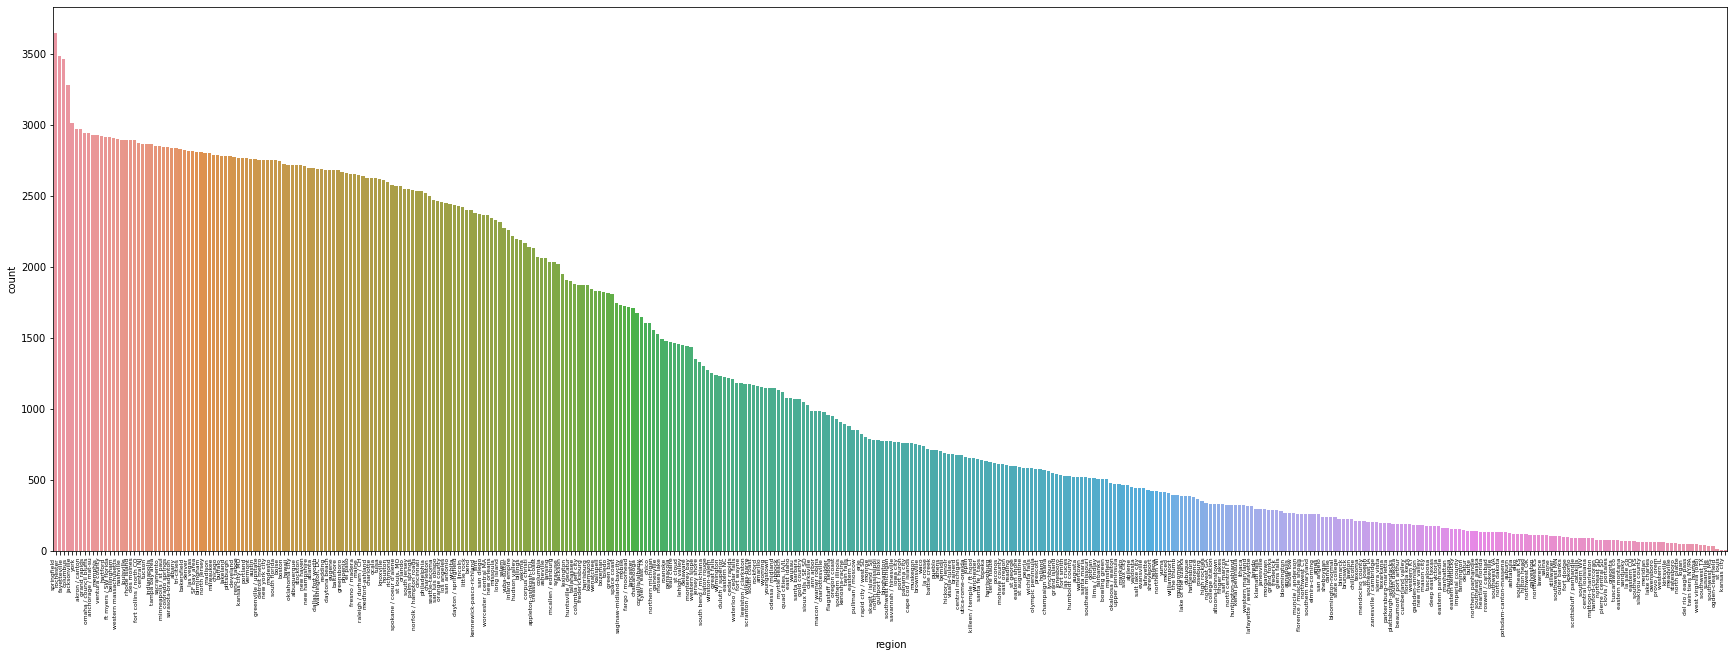

time: 4.85 s


In [22]:
plt.figure(figsize=(30,10))
ax = sns.countplot(x='region', data=df, order=df['region'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=6)
plt.show(ax)

Il numero degli annunci di vendita per ogni regione determina il valore dell'altezza del grafico.

Si osserva che la numerosità delle regioni è elevatissima

#### Year 

In [23]:
df.year.value_counts(dropna=False)

2017.0    35452
2016.0    34454
2015.0    34294
2013.0    34071
2014.0    32946
          ...  
1915.0        1
1913.0        1
1909.0        1
1945.0        1
0.0           1
Name: year, Length: 112, dtype: int64

time: 23.9 ms


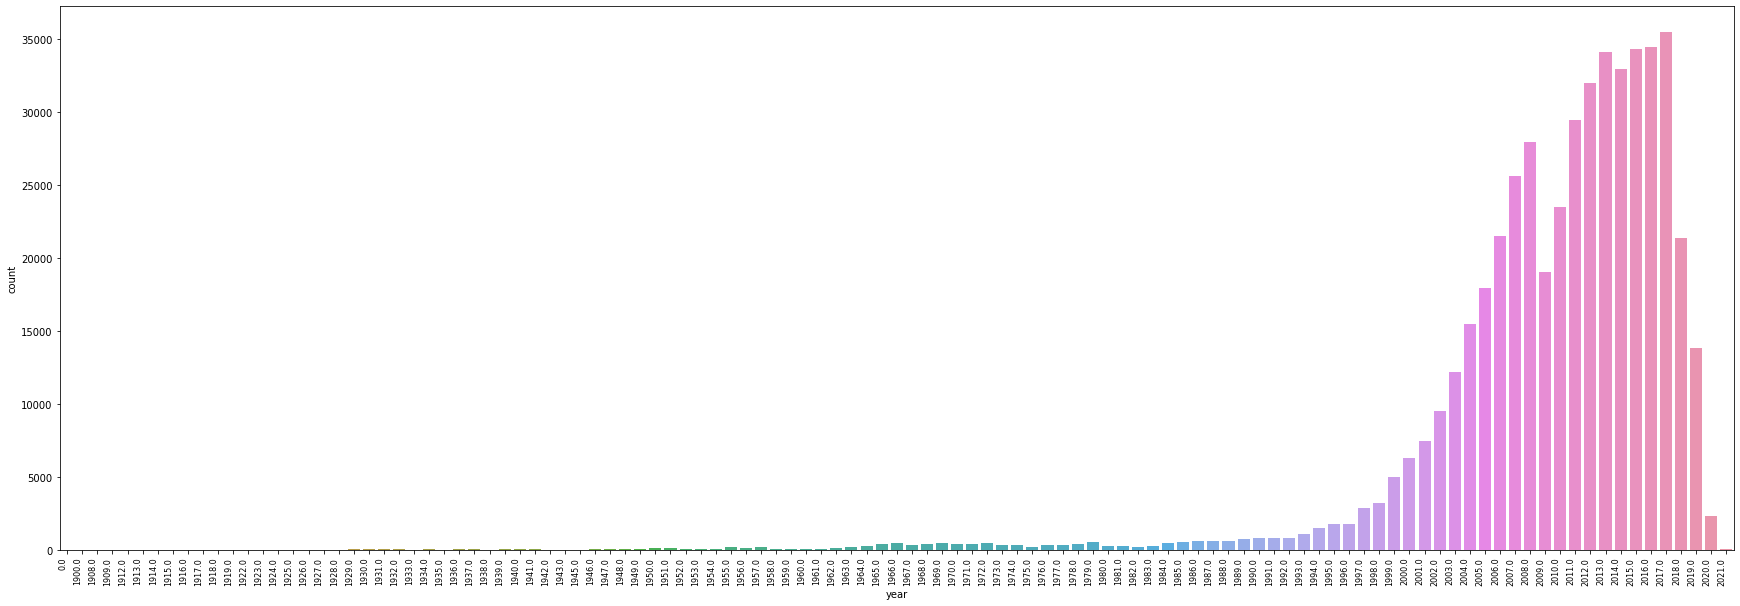

time: 1.3 s


In [24]:
plt.figure(figsize=(30,10))
ax = sns.countplot(x='year', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=8)
plt.show(ax)

In [25]:
df[df.year <= 1960].year.count()

2356

time: 11.6 ms


Si osserva che la numerosità degli annunci di veicoli risalenti ad anni precedenti al 1960 sono molto ridotti, si tratta di solo 2356 veicoli che verranno eliminati in quanto sono presenti molti errori di datazione.

In [26]:
df = df[df.year > 1960]

time: 77.5 ms


#### Manufacturer

In [27]:
df.manufacturer.isnull().sum()

19305

time: 27.8 ms


In [28]:
df.manufacturer.value_counts(dropna=False)

ford               88826
chevrolet          73203
toyota             36969
nissan             25607
honda              23904
jeep               23147
ram                23043
gmc                21730
NaN                19305
dodge              16729
bmw                13449
hyundai            11191
subaru             10971
mercedes-benz      10604
volkswagen         10073
kia                 8634
chrysler            8055
cadillac            7397
buick               6920
lexus               6093
mazda               5833
audi                5442
infiniti            3819
acura               3763
pontiac             3624
lincoln             3364
volvo               3039
mitsubishi          2465
mini                2281
rover               1825
mercury             1751
saturn              1702
jaguar              1093
fiat                 878
tesla                211
harley-davidson      209
alfa-romeo            79
datsun                66
ferrari               52
aston-martin          26


time: 58.8 ms


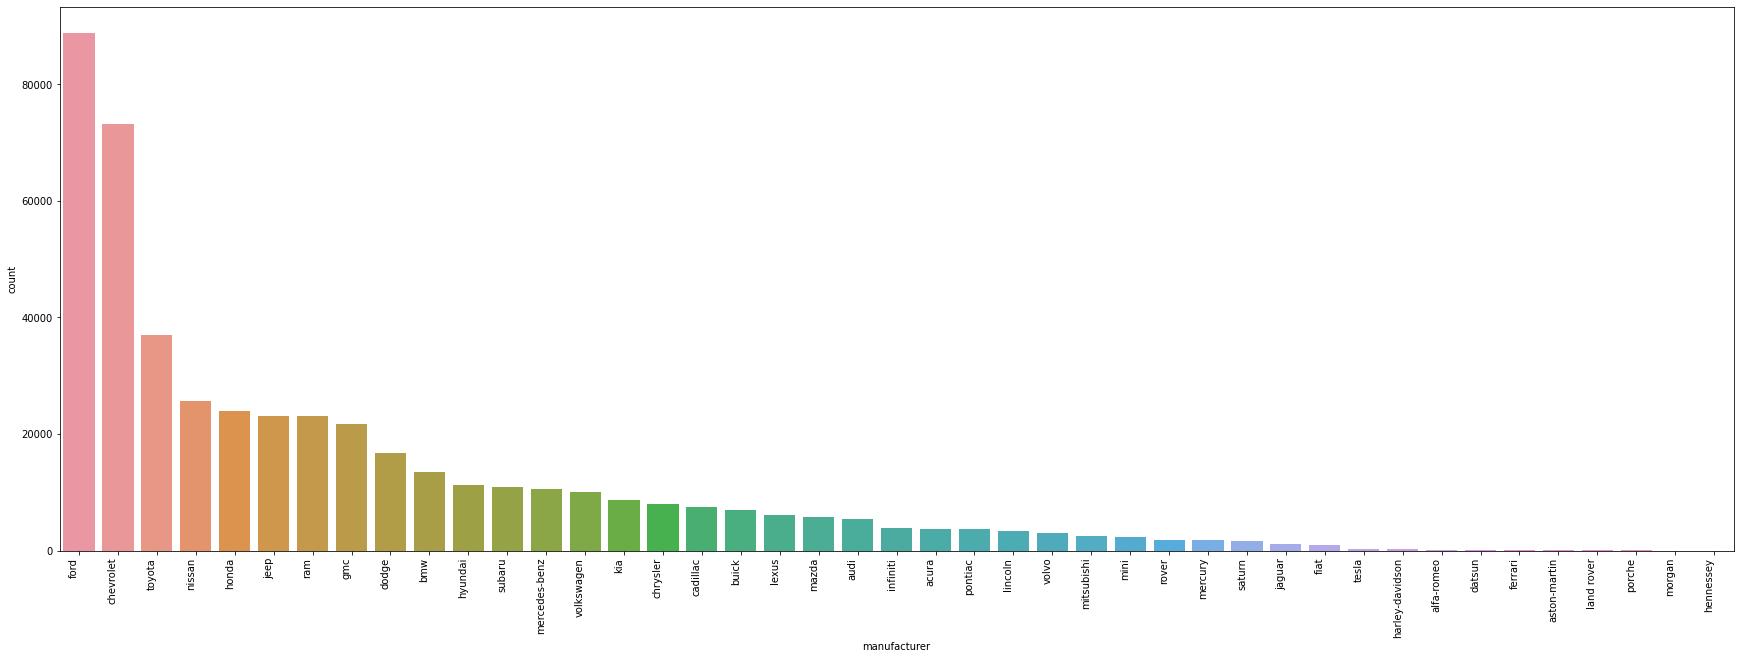

time: 618 ms


In [29]:
plt.figure(figsize=(30,10))
ax = sns.countplot(x='manufacturer', data=df, order=df['manufacturer'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=10)
plt.show(ax)

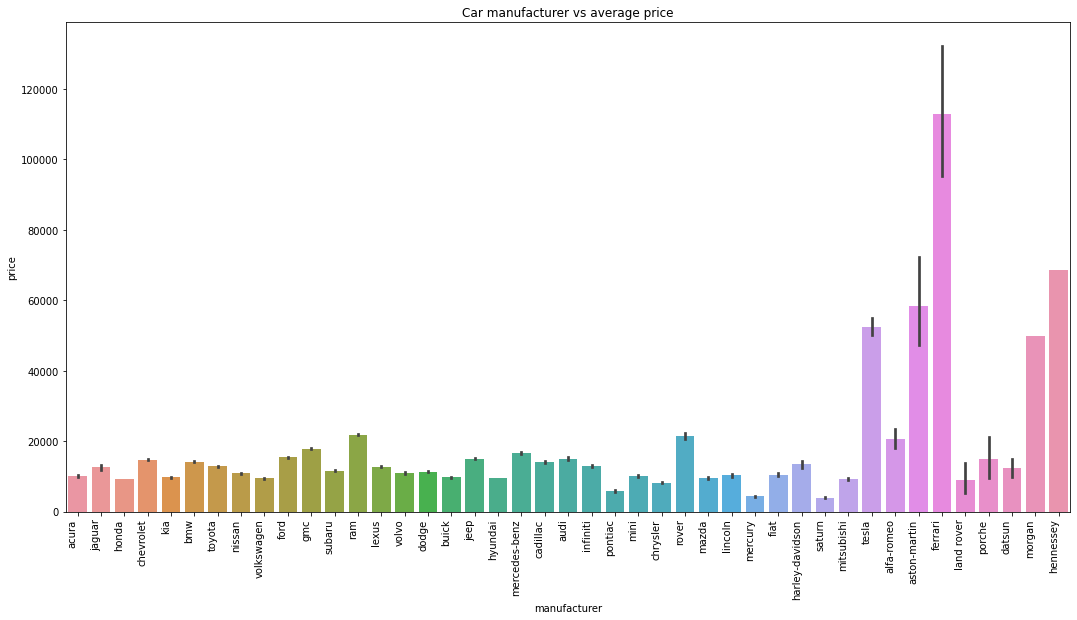

time: 6.27 s


In [30]:
(df.groupby(['manufacturer'])['price']).mean().sort_values(ascending=False)
plt.figure(figsize=(18,9))
ax = sns.barplot(x='manufacturer', y='price', data=df);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=10);
plt.title("Car manufacturer vs average price");

#### Model

In [31]:
df.model.isnull().sum()

6635

time: 36.7 ms


In [32]:
modello = df.model.value_counts().head(70)

time: 88.1 ms


Dato l'enorme numero di modelli, ai fini del progetto si decide di selezionare solamente i 70 modelli più popolari

In [33]:
df = df.loc[df.model.isin(modello.index)]

time: 66.5 ms


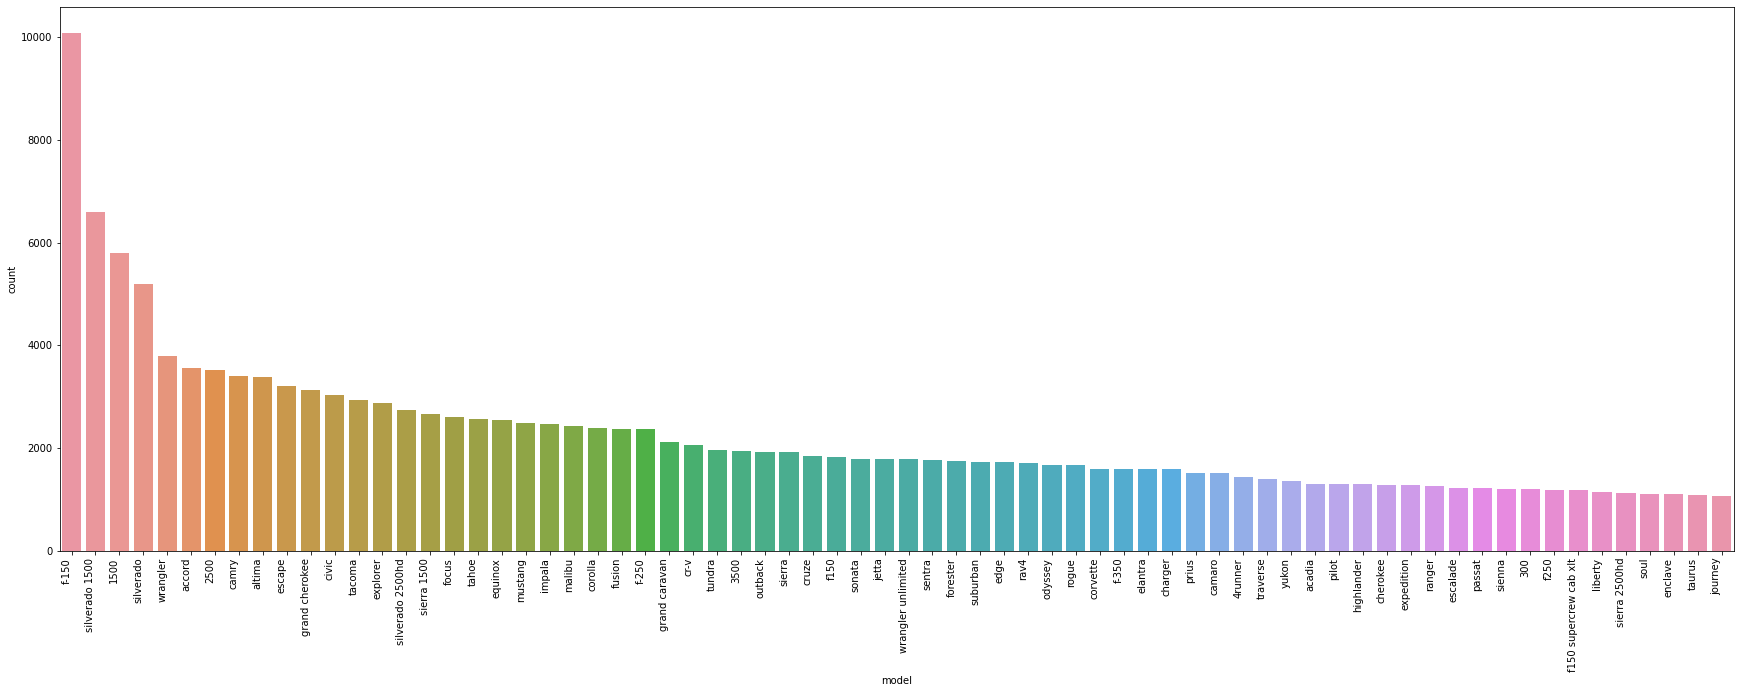

time: 962 ms


In [34]:
plt.figure(figsize=(30,10))
ax = sns.countplot(x='model', data=df, order=df['model'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.show(ax)

#### Condition

In [35]:
df.condition.isnull().sum()

77795

time: 19.4 ms


Si osserva un numero molto elevato di valori sconosciuti, essendo impossibile verificare la condizione del veicolo ed effettuare un replacement dei valori sconosciuti in modo affidabile si deciderà, nella fase successiva di preprocessing, di assegnare il valore "sconosciuto" a tali valori.

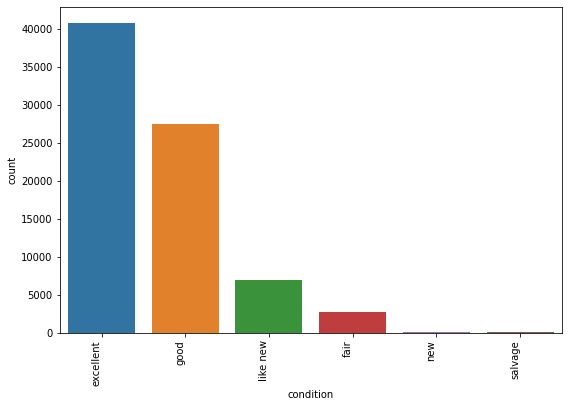

time: 188 ms


In [36]:
plt.figure(figsize=(9,6))
ax = sns.countplot(x='condition', data=df, order=df['condition'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.show(ax)

#### Cylinders

In [37]:
df.cylinders.isnull().sum()

64421

time: 14.9 ms


In [38]:
df.cylinders.value_counts(dropna=False)

NaN             64421
6 cylinders     30882
8 cylinders     30850
4 cylinders     29311
5 cylinders       433
other             192
10 cylinders      133
3 cylinders        53
12 cylinders        4
Name: cylinders, dtype: int64

time: 25.1 ms


Dato l'elevato numero di valori sconosciuti, si sostituirà il valore "Null" effettuando una riconciliazione dell'attributo in funzione del modello e del tipo di motore che monta.

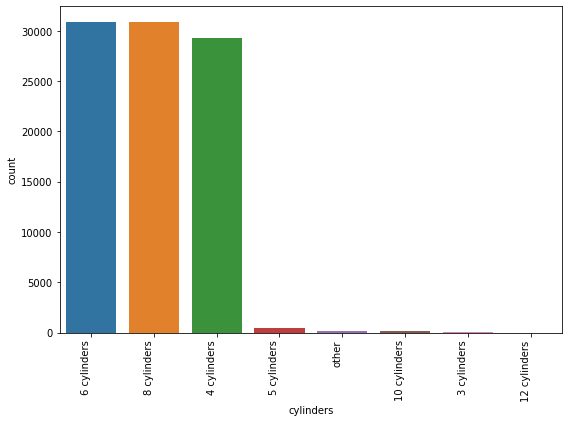

time: 206 ms


In [39]:
plt.figure(figsize=(9,6))
ax = sns.countplot(x='cylinders', data=df, order=df['cylinders'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.show(ax)

#### Fuel

In [40]:
df.fuel.isnull().sum()

658

time: 15.5 ms


In [41]:
df.fuel.value_counts(dropna=False)

gas         137808
diesel       11005
other         5534
hybrid        1240
NaN            658
electric        34
Name: fuel, dtype: int64

time: 27.8 ms


Anche in questo caso, i valori sconosciuti verranno sostituiti effettuando una riconciliazione dell'attributo in funzione del modello

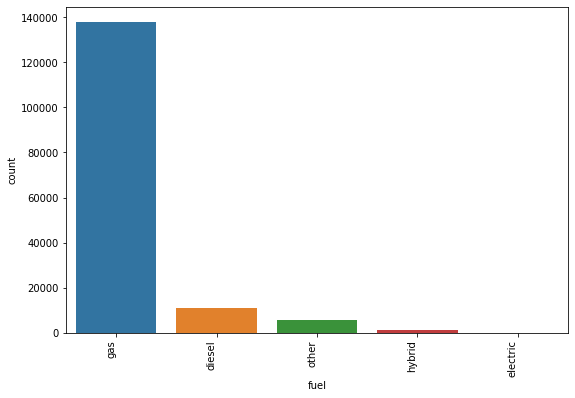

time: 190 ms


In [42]:
plt.figure(figsize=(9,6))
ax = sns.countplot(x='fuel', data=df, order=df['fuel'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.show(ax)

#### Odometer

In [43]:
df.odometer.isnull().sum()

28022

time: 4.13 ms


In [44]:
df.odometer.value_counts()

130000.0    392
0.0         381
150000.0    373
180000.0    367
160000.0    357
           ... 
82890.0       1
142296.0      1
82887.0       1
50804.0       1
145436.0      1
Name: odometer, Length: 52325, dtype: int64

time: 21.5 ms


Non essendo a conoscenza del chilometraggio di ciascun veicolo, si decide di sostituire i valori non noti con la dicitura "Sconosciuto".

La tipologia di attributo (continuo) impone di effettuare un binning dei valori, solo in seguito si proseguirà con una visualizzazione.

#### Title_status

In [45]:
df.title_status.isnull().sum()

676

time: 15.6 ms


In [46]:
df.title_status.value_counts(dropna=False)

clean         148286
rebuilt         4209
salvage         1822
lien            1147
NaN              676
missing           98
parts only        41
Name: title_status, dtype: int64

time: 36.9 ms


Non essendo a conoscenza della storia del veicolo, i valori sconosciuti verranno successivamente sostituiti con il valore "clean" corrispondente alla moda.

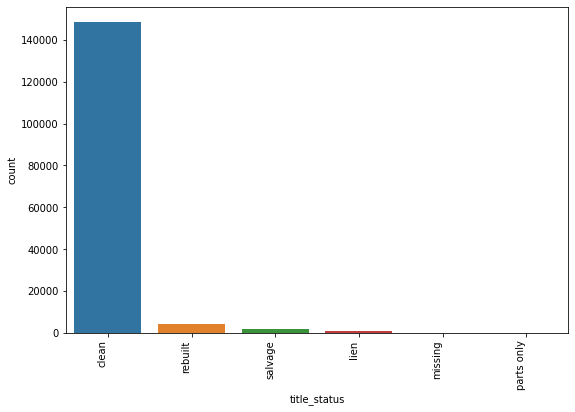

time: 202 ms


In [47]:
plt.figure(figsize=(9,6))
ax = sns.countplot(x='title_status', data=df, order=df['title_status'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.show(ax)

#### Transmission

In [48]:
df.transmission.isnull().sum()

1617

time: 16.5 ms


In [49]:
df.transmission.value_counts(dropna=False)

automatic    143960
manual         8245
other          2457
NaN            1617
Name: transmission, dtype: int64

time: 26.8 ms


Vista la scarsissima percentuale di valori "manual", si procederà successivamente a sostituire i valori NaN con il valore indicato dalla moda ("automatic").

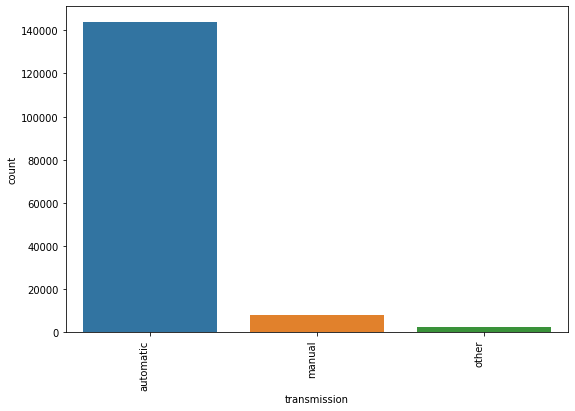

time: 186 ms


In [50]:
plt.figure(figsize=(9,6))
ax = sns.countplot(x='transmission', data=df, order=df['transmission'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.show(ax)

#### Drive

In [51]:
df.drive.isnull().sum()

40738

time: 13.7 ms


In [52]:
df.drive.value_counts(dropna=False)

4wd    60610
NaN    40738
fwd    39010
rwd    15921
Name: drive, dtype: int64

time: 30.1 ms


L'analisi delle tipologie di trazione dell'autoveicolo porta all'individuazione di moleplici valori nulli. Verrà effettuata successivamente la riconciliazione in base al modello del veicolo.

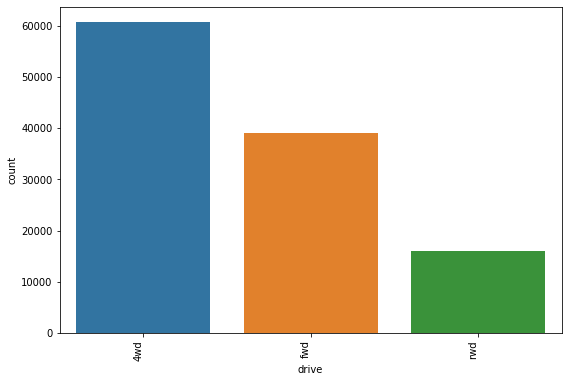

time: 170 ms


In [53]:
plt.figure(figsize=(9,6))
ax = sns.countplot(x='drive', data=df, order=df['drive'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.show(ax)

#### Type

In [54]:
df.type.isnull().sum()

43760

time: 17.1 ms


In [55]:
df.type.value_counts(dropna=False)

NaN            43760
SUV            30233
sedan          26126
pickup         22437
truck          18252
coupe           3802
wagon           3411
mini-van        2137
hatchback       2028
other           1517
convertible     1151
van             1092
offroad          323
bus               10
Name: type, dtype: int64

time: 26.9 ms


L'analisi delle tipologie di veicolo porta all'individuazione di altri, tanti, valori nulli. Verrà effettuata successivamente la riconciliazione in base al modello del veicolo.

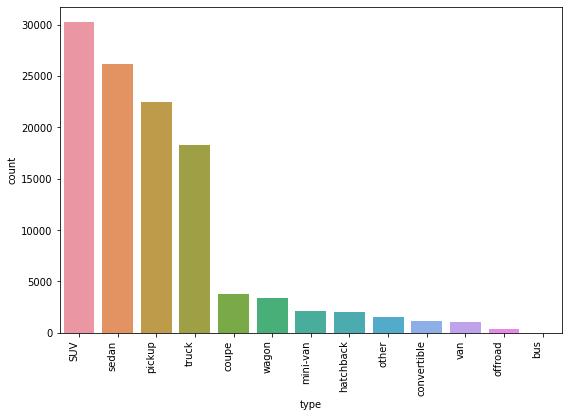

time: 241 ms


In [56]:
plt.figure(figsize=(9,6))
ax = sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.show(ax)

#### Paint color

In [57]:
df.paint_color.isnull().sum()

50372

time: 18.2 ms


In [58]:
df.paint_color.value_counts(dropna=False)

NaN       50372
white     25768
black     21296
silver    16211
red       11150
blue      10884
grey      10186
green      3297
custom     3228
brown      2517
yellow      594
orange      582
purple      194
Name: paint_color, dtype: int64

time: 35.5 ms


Per quanto riguarda i dati estratti relativi al colore degli autoveicoli presentati negli annunci, si rileva una grande presenza di valori nulli che viene sostituita con un più comodo valore "Sconosciuto"

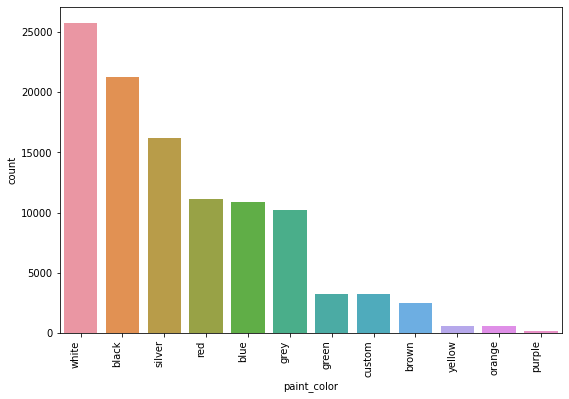

time: 220 ms


In [59]:
plt.figure(figsize=(9,6))
ax = sns.countplot(x='paint_color', data=df, order=df['paint_color'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.show(ax)

#### State

In [60]:
df.state.isnull().sum()

0

time: 16.4 ms


In [61]:
df.state.value_counts(dropna=False)

ca    14078
tx    10253
fl     9380
mi     8988
ny     6850
oh     6270
wi     5018
or     4961
pa     4564
tn     4480
nc     4460
va     4292
co     4044
mn     3862
wa     3825
ia     3676
il     3640
mt     3346
ma     3130
id     2841
al     2778
nj     2749
mo     2659
in     2450
az     2389
ks     2362
ok     2227
ky     2187
ct     2106
ar     2090
sc     2077
ga     2036
la     1692
nm     1427
md     1426
ak     1378
ms     1073
me      987
nh      921
dc      894
ne      849
vt      826
ri      795
nv      755
sd      746
hi      739
wy      448
de      391
ut      334
wv      306
nd      224
Name: state, dtype: int64

time: 26.2 ms


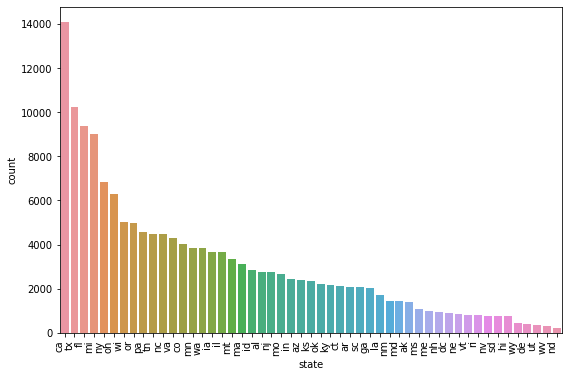

time: 571 ms


In [62]:
plt.figure(figsize=(9,6))
ax = sns.countplot(x='state', data=df, order=df['state'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.show(ax)

# Preprocessing

In [63]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
6,greensboro,10995,2014.0,chevrolet,traverse,NaN,NaN,gas,112383.0,clean,automatic,fwd,SUV,black,nc
9,greensboro,8995,2005.0,toyota,tacoma,NaN,NaN,gas,181020.0,clean,automatic,NaN,other,black,nc
12,greensboro,5495,2008.0,ford,edge,NaN,NaN,gas,139904.0,clean,automatic,NaN,SUV,NaN,nc
14,denver,8990,2016.0,ford,focus,NaN,NaN,gas,78877.0,clean,automatic,NaN,hatchback,white,co
15,denver,7500,2012.0,toyota,camry,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,co


time: 33.8 ms


Si procede ora con la fase di preprocessing specifica per ogni attributo.

I dataframe prodotti in questo notebook vengono riutilizzati anche nel notebook successivo 'NB2 - Progetto BDIE'

###Manufacturer

In [64]:
df.manufacturer.value_counts(dropna=False)

ford             37122
chevrolet        33057
toyota           17837
honda            11619
jeep             11117
ram              10476
gmc               8538
nissan            6821
dodge             4915
subaru            3679
hyundai           3373
volkswagen        2992
cadillac          1232
chrysler          1194
kia               1110
buick             1104
NaN                 85
mercedes-benz        5
saturn               1
lexus                1
mazda                1
Name: manufacturer, dtype: int64

time: 32.4 ms


In [65]:
df[df.manufacturer.isnull()]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
5921,kennewick-pasco-richland,4300,2006.0,NaN,mustang,NaN,6 cylinders,gas,NaN,salvage,automatic,NaN,coupe,grey,wa
43265,pittsburgh,26900,2007.0,NaN,corvette,excellent,8 cylinders,gas,26900.0,clean,automatic,rwd,NaN,red,pa
44194,catskills,50000,1969.0,NaN,camaro,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,ny
53150,eau claire,17988,2011.0,NaN,sierra,excellent,8 cylinders,gas,79700.0,clean,automatic,4wd,truck,grey,wi
53328,eau claire,21988,2016.0,NaN,explorer,excellent,6 cylinders,gas,77350.0,clean,automatic,4wd,SUV,brown,wi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493535,charleston,2000,1973.0,NaN,ranger,good,8 cylinders,gas,NaN,clean,automatic,rwd,pickup,blue,sc
498173,yuba-sutter,4000,2005.0,NaN,4runner,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,ca
503605,colorado springs,2000,1986.0,NaN,camaro,NaN,6 cylinders,gas,NaN,clean,automatic,NaN,NaN,red,co
528047,knoxville,2500,2007.0,NaN,sonata,good,6 cylinders,gas,240000.0,clean,automatic,fwd,NaN,NaN,tn


time: 55.8 ms


Si effettua un replacement dei valori NaN con il manufacturer corretto in base ad una riconciliazione dell'attributo sul valore del modello

In [66]:
df.manufacturer = df.groupby('model').manufacturer.transform(lambda x: x.fillna(x.mode()[0]))

time: 133 ms


In [67]:
df.manufacturer.value_counts(dropna=False)

ford             37143
chevrolet        33089
toyota           17848
honda            11623
jeep             11119
ram              10476
gmc               8540
nissan            6825
dodge             4916
subaru            3679
hyundai           3376
volkswagen        2997
cadillac          1232
chrysler          1194
kia               1110
buick             1104
mercedes-benz        5
mazda                1
lexus                1
saturn               1
Name: manufacturer, dtype: int64

time: 27 ms


### Model

Si vogliono rendere univoci i nomi con cui compaiono i singoli modelli

##### Chevrolet

In [68]:
df.loc[(df.manufacturer == 'chevrolet') & ((df.model == 'silverado') |(df.model == '1500')), 'model'] = 'silverado 1500'
df.loc[(df.manufacturer == 'chevrolet') & ((df.model == 'silverado 2500hd') |(df.model == '2500')), 'model'] = 'silverado 2500'
df.loc[(df.manufacturer == 'chevrolet') & ((df.model == '3500')), 'model'] = 'silverado 3500'

time: 101 ms


In [69]:
df.loc[(df.manufacturer == 'chevrolet') & ((df.model == 'sierra 1500') | (df.model == 'sierra')), 'manufacturer'] = 'gmc'
df.loc[(df.manufacturer == 'chevrolet') & ((df.model == 'yukon')), 'manufacturer'] = 'gmc'
df.loc[(df.manufacturer == 'chevrolet') & ((df.model == 'tundra')), 'manufacturer'] = 'toyota'

time: 100 ms


#####Chrysler

In [70]:
df.loc[(df.manufacturer == 'chrysler') & ((df.model == 'grand caravan')), 'manufacturer'] = 'dodge'

time: 30.6 ms


#####Dodge

In [71]:
df.loc[(df.manufacturer == 'dodge') & ((df.model == '1500') | (df.model == '2500') | (df.model == '3500')), 'manufacturer'] = 'ram'
df.loc[(df.manufacturer == 'dodge') & ((df.model == 'sierra 1500') | (df.model == 'sierra')), 'manufacturer'] = 'gmc'
df.loc[(df.manufacturer == 'dodge') & ((df.model == 'impala')), 'manufacturer'] = 'chevrolet'
df.loc[(df.manufacturer == 'dodge') & ((df.model == 'tacoma')), 'manufacturer'] = 'toyota'

time: 134 ms


#####Ford

In [72]:
df.loc[(df.manufacturer == 'ford') & ((df.model == 'f150') | (df.model == 'f150 supercrew cab xlt')), 'model'] = 'f-150'
df.loc[(df.manufacturer == 'ford') & ((df.model == 'f250')), 'model'] = 'f-250'

time: 65 ms


##### GMC

In [73]:
df.loc[(df.manufacturer == 'gmc') & ((df.model == 'silverado')), 'model'] = 'silverado 1500'
df.loc[(df.manufacturer == 'gmc') & ((df.model == 'silverado 1500')), 'manufacturer'] = 'chevrolet'
df.loc[(df.manufacturer == 'gmc') & ((df.model == 'sierra') | (df.model == '1500')), 'model'] = 'sierra 1500'
df.loc[(df.manufacturer == 'gmc') & ((df.model == 'sierra 2500hd') | (df.model == '2500')), 'model'] = 'sierra 2500'
df.loc[(df.manufacturer == 'gmc') & ((df.model == '3500')), 'model'] = 'sierra 3500'

time: 148 ms


##### Honda

In [74]:
df.loc[(df.manufacturer == 'honda') & ((df.model == 'fusion')), 'manufacturer'] = 'ford'
df.loc[(df.manufacturer == 'honda') & ((df.model == 'highlander')), 'manufacturer'] = 'toyota'

time: 58.5 ms


#####Kia

In [75]:
df.loc[(df.manufacturer == 'kia') & ((df.model == 'sonata')), 'manufacturer'] = 'hyundai'

time: 32.2 ms


##### Saturn

In [76]:
df.loc[(df.manufacturer == 'saturn') & ((df.model == 'outback')), 'manufacturer'] = 'subaru'

time: 34.8 ms


##### RAM

In [77]:
df.loc[(df.manufacturer == 'ram') & ((df.model == 'charger')), 'manufacturer'] = 'dodge'

time: 34.3 ms


##### Toyota

In [78]:
df.loc[(df.manufacturer == 'toyota') & ((df.model == 'odyssey')), 'manufacturer'] = 'honda'

time: 31.5 ms


#####Altre operazioni

I seguenti produttori di auto sono stati inseriti nel dataset dei 70 modelli più popolari solamente per un'ambiguità nel nome del proprio modello, si decide pertanto di estrometterli.

In [79]:
df = df[df.manufacturer != 'lexus']
df = df[df.manufacturer != 'mazda']
df = df[df.manufacturer != 'mercedes-benz']

time: 97.8 ms


In [80]:
pd.set_option('display.max_rows', None)
df.groupby(by='manufacturer').model.value_counts()

manufacturer  model             
buick         enclave                1104
cadillac      escalade               1232
chevrolet     silverado 1500        11958
              silverado 2500         2906
              tahoe                  2565
              equinox                2549
              impala                 2469
              malibu                 2427
              cruze                  1851
              suburban               1688
              corvette               1594
              camaro                 1508
              traverse               1404
              silverado 3500          168
              explorer                  1
chrysler      300                    1192
dodge         grand caravan          2120
              charger                1585
              journey                1075
ford          f-150                 13079
              f-250                  3564
              escape                 3214
              explorer               2885
 

time: 60.5 ms


### Price

Si decide di eliminare gli outlier per non avere valori isolati ed avere degli intervalli continui di prezzo contenenti un numero sufficiente di modelli

In [81]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 3)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

df = df[~df.groupby('model')['price'].apply(is_outlier)]

time: 145 ms


Si applica un binning per stabilire degli intervalli di dimensione 5000 dollari di valore delle varie automobili e semplificare la classificazione.

In [82]:
filter = range(0, 80000, 5000)
df.price = pd.cut(df.price, bins=filter)

time: 15.3 ms


In [83]:
df.price.head()

6     (10000, 15000]
9      (5000, 10000]
12     (5000, 10000]
14     (5000, 10000]
15     (5000, 10000]
Name: price, dtype: category
Categories (15, interval[int64]): [(0, 5000] < (5000, 10000] < (10000, 15000] < (15000, 20000] <
                                   ... < (55000, 60000] < (60000, 65000] < (65000, 70000] <
                                   (70000, 75000]]

time: 11.2 ms


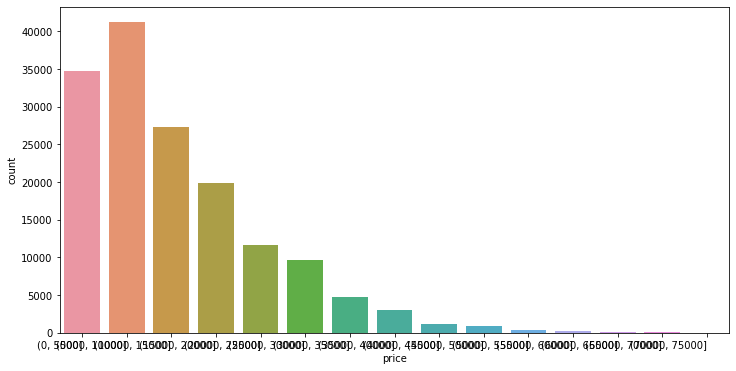

time: 3.72 s


In [84]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x='price', data=df)
ax.set_xticklabels(ax.get_xticklabels(), ha="right", fontsize=10)
plt.show(ax)

Si ritrasforma la variabile dipendente in variabile numerica

In [85]:
encoder = LabelEncoder()
df.price = df.price.astype(str)
df.price = encoder.fit_transform(df.price)

time: 920 ms


Si uniscono gli ultimi due bin poiché l'ultimo bin contiene un solo elemento che verrebbe trainato ma mai testato (o viceversa).

In [86]:
df.loc[df.price == 15, 'price'] = 14

time: 1.3 s


### Year

Vengono eliminati tutti i modelli che contengono un annuncio relativo al 2021 pertanto non ancora in commercio

In [87]:
df = df[df.year < 2021]

time: 29.8 ms


In [88]:
df.year = df.year.astype('int')

time: 5.83 ms


### Condition

I valori nulli vengono rimpiazzati con "Sconosciuto"

In [89]:
df.condition.replace(to_replace=np.nan, value='Sconosciuto', inplace=True)

time: 18.7 ms


In [90]:
df.condition = encoder.fit_transform(df.condition)

time: 44.1 ms


### Fuel

Nel caso in cui la tipologia di carburante non sia specificata, si sostituiscono i valori nulli con la moda di tale valore relativa al proprio modello

In [91]:
df.fuel = df.groupby('model').fuel.transform(lambda x: x.fillna(x.mode()[0]))

time: 144 ms


In [92]:
df.fuel.value_counts(dropna=False)

gas         137506
diesel       10969
other         5504
hybrid        1225
electric        33
Name: fuel, dtype: int64

time: 24.6 ms


In [93]:
df.fuel = encoder.fit_transform(df.fuel)

time: 44.1 ms


### Cylinders

La stessa procedura seguita per il carburante viene applicata anche al numero di cilindri, con la differenza che in questo caso viene considerata la coppia modello-carburante.

In [94]:
df.cylinders.value_counts(dropna=False)

NaN             63805
6 cylinders     30729
8 cylinders     30722
4 cylinders     29173
5 cylinders       432
other             187
10 cylinders      133
3 cylinders        52
12 cylinders        4
Name: cylinders, dtype: int64

time: 24.7 ms


In [95]:
df.cylinders = df.cylinders.astype(str)

time: 29.1 ms


In [96]:
df.cylinders.value_counts(dropna=False)

nan             63805
6 cylinders     30729
8 cylinders     30722
4 cylinders     29173
5 cylinders       432
other             187
10 cylinders      133
3 cylinders        52
12 cylinders        4
Name: cylinders, dtype: int64

time: 27.6 ms


In [97]:
df.cylinders.value_counts(dropna = False).index[0]

'nan'

time: 28.7 ms


In [98]:
df.cylinders = df.groupby(["model", "fuel"])["cylinders"].transform(lambda x: x.replace(to_replace = "nan", value = x.mode()[0]))

time: 321 ms


In [99]:
print(df.shape)
df.cylinders.value_counts(dropna = False)

(155237, 15)


8 cylinders     48297
4 cylinders     46547
6 cylinders     44863
nan             14721
5 cylinders       432
other             188
10 cylinders      133
3 cylinders        52
12 cylinders        4
Name: cylinders, dtype: int64

time: 27.6 ms


In [100]:
df = df[df.cylinders!= "nan"]
print(df.shape)
df.cylinders.value_counts(dropna = False)

(140516, 15)


8 cylinders     48297
4 cylinders     46547
6 cylinders     44863
5 cylinders       432
other             188
10 cylinders      133
3 cylinders        52
12 cylinders        4
Name: cylinders, dtype: int64

time: 53.2 ms


In [101]:
df.head(10)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
9,greensboro,9,2005,toyota,tacoma,0,6 cylinders,2,181020.0,clean,automatic,NaN,other,black,nc
14,denver,9,2016,ford,focus,0,4 cylinders,2,78877.0,clean,automatic,NaN,hatchback,white,co
15,denver,9,2012,toyota,camry,0,4 cylinders,2,NaN,clean,automatic,NaN,NaN,NaN,co
16,greensboro,1,2009,gmc,yukon,0,8 cylinders,2,146353.0,clean,automatic,4wd,SUV,black,nc
17,greensboro,1,2009,gmc,yukon,0,8 cylinders,2,146353.0,clean,automatic,4wd,SUV,black,nc
18,greensboro,9,2011,subaru,outback,0,4 cylinders,2,135775.0,clean,NaN,NaN,wagon,NaN,nc
30,greensboro,9,2004,ford,f-150,0,8 cylinders,2,162867.0,clean,automatic,4wd,pickup,red,nc
32,greensboro,6,2016,ram,2500,0,6 cylinders,0,99801.0,clean,automatic,4wd,pickup,black,nc
34,syracuse,0,2003,jeep,liberty,2,6 cylinders,2,146260.0,clean,automatic,4wd,NaN,NaN,ny
38,greensboro,9,2007,toyota,tundra,0,8 cylinders,2,225667.0,clean,automatic,fwd,pickup,white,nc


time: 45.6 ms


Si nota che alcune combinazioni di modello-carburante hanno un numero di cilindri non noto (NaN è la moda)

In [102]:
df[df.model == "traverse"].groupby(["fuel", "cylinders"]).cylinders.count()

fuel  cylinders   
2     10 cylinders      1
      3 cylinders       1
      4 cylinders       3
      6 cylinders     662
4     6 cylinders       3
Name: cylinders, dtype: int64

time: 21.5 ms


Encoding valori

In [103]:
df.cylinders = encoder.fit_transform(df.cylinders)

time: 40 ms


### Odometer

In [104]:
df.odometer.replace(to_replace = np.nan, value = 'Sconosciuto', inplace=True)

time: 18.4 ms


In [105]:
df[df.odometer == 0].odometer.count()

343

time: 37.1 ms


Viene eseguito un binning dei valori, distinguendo i valori sconosciuti dai valori noti

In [106]:
df_nan = df[df.odometer == 'Sconosciuto']
df_noti = df[df.odometer != 'Sconosciuto']

time: 42.4 ms


In [107]:
df_noti.odometer = df_noti.odometer / 1000
df_noti.odometer = df_noti.odometer.astype('int')

time: 35.2 ms


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [108]:
df_noti.loc[(df_noti.odometer >= 3000) | (df_noti.odometer >= 1000) & (df_noti.year > 2010)].odometer = 'Sconosciuto'

time: 14.8 ms


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [109]:
print(df_noti.shape, df_nan.shape)

(115816, 15) (24700, 15)
time: 2.88 ms


In [110]:
df = pd.concat([df_nan, df_noti])

time: 36.7 ms


In [111]:
df_nan = df[df.odometer == 'Sconosciuto']
df_noti = df[df.odometer != 'Sconosciuto']

time: 65.1 ms


In [112]:
print(df_noti.shape, df_nan.shape)

(115816, 15) (24700, 15)
time: 2.37 ms


In [113]:
df_noti.odometer = df_noti.odometer.astype('int')

time: 18.8 ms


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [114]:
filter = [-1, 20, 40, 60, 80, 100,
          150, 200, 250, 300, 500,
          3001]
df_noti.odometer = pd.cut(df_noti.odometer, bins=filter)

time: 14.5 ms


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


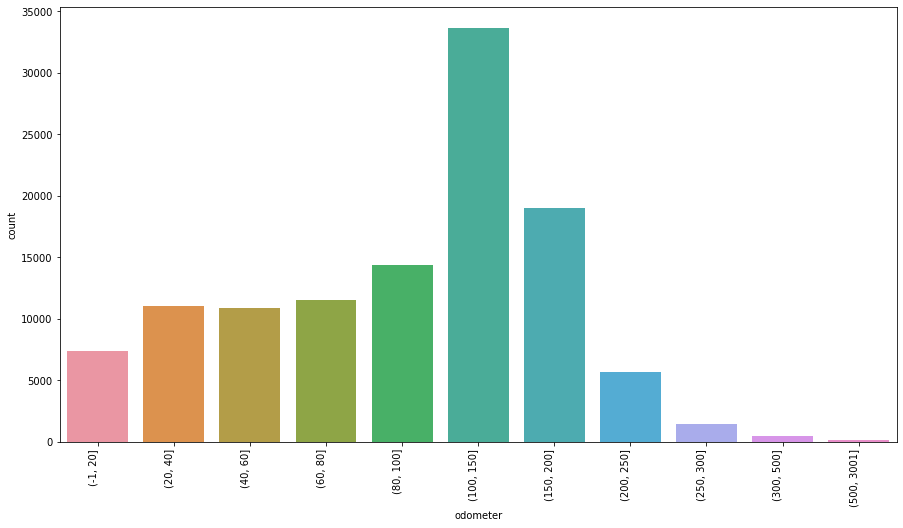

time: 2.79 s


In [115]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='odometer', data=df_noti)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=10)
plt.show(ax)

In [116]:
df_noti.odometer = df_noti.odometer.astype(str)
df_noti = df_noti[df_noti.odometer != 'nan']

time: 640 ms


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [117]:
df_noti.odometer = df_noti.odometer.replace(
                            {'(-1.0, 20.0]': 0,
                            '(20.0, 40.0]': 1,
                            '(40.0, 60.0]': 2,
                            '(60.0, 80.0]': 3,
                            '(80.0, 100.0]': 4,
                            '(100.0, 150.0]': 5,
                            '(150.0, 200.0]': 6,
                            '(200.0, 250.0]': 7,
                            '(250.0, 300.0]': 8,
                            '(300.0, 500.0]': 9,
                            '(500.0, 3001.0]': 10})

time: 92.1 ms


In [118]:
df_noti.odometer.value_counts(dropna=False)

5     33675
6     19043
4     14410
3     11528
1     11054
2     10918
0      7422
7      5715
8      1469
9       438
10      131
Name: odometer, dtype: int64

time: 9.3 ms


In [119]:
df = pd.concat([df_nan, df_noti])

time: 40.8 ms


I valori sconosciuti vengono assegnati ad un valore categorico diverso rispetto ai valori noti, in modo da poterli considerare separatamente

In [120]:
df.odometer.replace(to_replace='Sconosciuto', value=11, inplace=True)

time: 34.4 ms


In [121]:
df.odometer.value_counts()

5     33675
11    24700
6     19043
4     14410
3     11528
1     11054
2     10918
0      7422
7      5715
8      1469
9       438
10      131
Name: odometer, dtype: int64

time: 11.1 ms


### Title_status

Si sostituiscono i valori mancanti rimpiazzandoli con i valori corrispondenti alla moda

In [122]:
df.title_status.replace(to_replace=np.nan, value=df.title_status.mode()[0], inplace=True)
df.title_status.replace(to_replace='missing', value=df.title_status.mode()[0], inplace=True)

time: 38.3 ms


In [123]:
df.title_status.value_counts(dropna=False)

clean         133588
rebuilt         4019
salvage         1765
lien            1094
parts only        37
Name: title_status, dtype: int64

time: 24.3 ms


In [124]:
df.title_status = encoder.fit_transform(df.title_status)

time: 36 ms


### Transmission

Si sostituiscono i valori mancanti rimpiazzandoli con i valori corrispondenti alla moda

In [125]:
df.transmission.value_counts(dropna=False)

automatic    129756
manual         7518
other          2071
NaN            1158
Name: transmission, dtype: int64

time: 25.1 ms


In [126]:
df.transmission.replace(to_replace=np.nan, value='automatic', inplace=True)

time: 14.6 ms


In [127]:
df.transmission = encoder.fit_transform(df.transmission)

time: 34.6 ms


### Drive

In [128]:
df.drive.value_counts(dropna=False)

4wd    55772
fwd    36230
NaN    33715
rwd    14786
Name: drive, dtype: int64

time: 18.8 ms


Per quanto riguarda i dati relativi alla trazione si è deciso di integrare i dati mancanti con i corrispondenti relativi al modello, da cui si è selezionata la moda per ogni modello

In [129]:
df.drive = df.groupby("model")["drive"].transform(
    lambda x: x.replace(to_replace=np.nan, value=x.mode()[0]) if len(x.mode()) != 0 else 'Sconosciuto')

time: 177 ms


In [130]:
df.drive = encoder.fit_transform(df.drive)

time: 36.8 ms


### Type

Per quanto riguarda i dati relativi alla tipologia di autoveicolo si è deciso di integrare i dati mancanti con i corrispondenti relativi al modello, da cui si è selezionata la moda per ogni modello

In [131]:
df.type.value_counts(dropna=False)

NaN            37944
SUV            27924
sedan          24392
pickup         18764
truck          17937
wagon           3287
coupe           3145
mini-van        2016
hatchback       1705
other           1078
van             1043
convertible      939
offroad          320
bus                9
Name: type, dtype: int64

time: 27.2 ms


In [132]:
df.type = df.groupby("model")["type"].transform(
    lambda x: x.replace(to_replace=np.nan, value=x.mode()[0]) if len(x.mode()) != 0 else 'Sconosciuto')

time: 163 ms


In [133]:
df.type.value_counts(dropna=False)

SUV            38515
sedan          34768
truck          25975
pickup         24069
wagon           4201
coupe           3991
mini-van        3482
hatchback       2113
other           1078
van             1043
convertible      939
offroad          320
bus                9
Name: type, dtype: int64

time: 25.8 ms


In [134]:
df.type = encoder.fit_transform(df.type)

time: 42 ms


### Paint color

La variabile presa in esame richiede una semplice sostituszione dei valori nulli in "Sconosciuto"

In [135]:
df.paint_color.value_counts(dropna=False)

NaN       43157
white     22954
black     19119
silver    14940
red       10326
blue      10113
grey       9950
custom     3195
green      3136
brown      2366
yellow      543
orange      512
purple      192
Name: paint_color, dtype: int64

time: 23.7 ms


In [136]:
df.paint_color.replace(to_replace=np.nan, value='Sconosciuto', inplace=True)

time: 16.2 ms


In [137]:
df.paint_color = encoder.fit_transform(df.paint_color)

time: 39.7 ms


### Region

La vaiabile "region" non contiene anomalie o dati mancanti per cui si esegue solamente l'encoding

In [138]:
df.region = encoder.fit_transform(df.region)

time: 46.5 ms


### State

Come per la regione, si procede ugualmente per la variabile "state"

In [139]:
df.state = encoder.fit_transform(df.state)

time: 32.6 ms


### Encoding finale

È ora possibile eseguire l'encoding delle variabili "manufacturer" e "model"

In [140]:
df.manufacturer = encoder.fit_transform(df.manufacturer)
df.model = encoder.fit_transform(df.model)

time: 66.3 ms


## Matrice di correlazione

In [141]:
data_corr = df[['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'type', 'paint_color', 'state']]

time: 22 ms


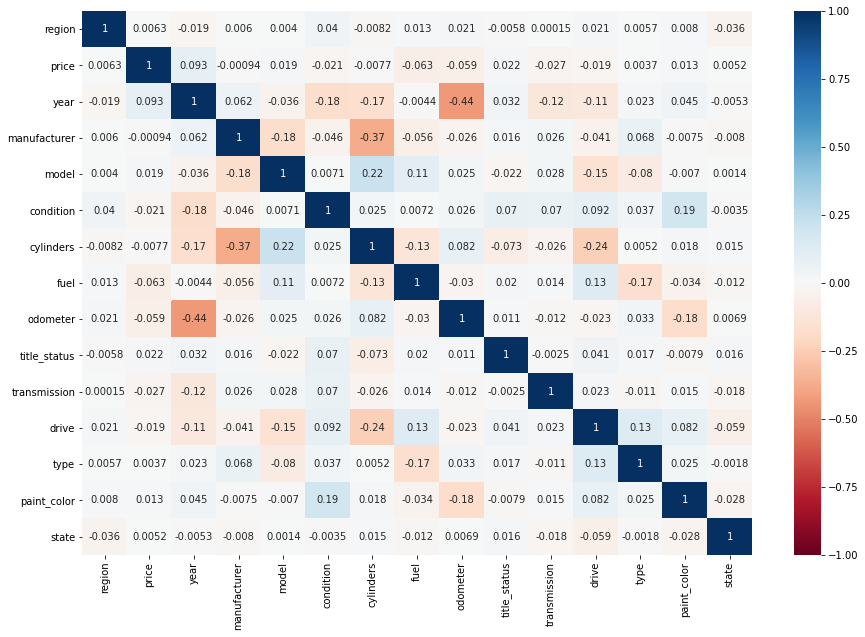

time: 1.27 s


In [142]:
plt.figure(figsize=(15,10))
sns.heatmap(data_corr.corr(), cmap='RdBu', annot=True, vmax = 1, vmin = -1)
plt.show()

La matrice di correlazione non evidenzia particolari correlazioni tra gli attributi.